# Coursework 2
## MTH739P: Topics in Scientific Computing
### Gerardo Duran Martín

In [339]:
versioninfo()

Julia Version 1.5.3
Commit 788b2c77c1 (2020-11-09 13:37 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i7-7820HQ CPU @ 2.90GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)


In [340]:
using Plots
using LinearAlgebra
using LaTeXStrings

In [341]:
default(size=(600, 300))
new = [CartesianIndex()];

## Question 1: pseudospectral methods

### a) Evaluation of a first derivative

Write a program that numerically evaluates the first derivative using pseudo-spectral methods of a function $f(x)$ evaluated a set of grid of points  $\left\{x_n = \frac{a + b}{2} + \frac{a - b}{2}\cos\theta_n\right\}_{n=0}^N$; where $a, b$ are the limits of the evaluation interval, $\theta_n = n\pi / N$. Evaluate the derivatives using the approximation

$$
    f'(x_n) = \sum_{m=0}^N D_{nm}f(x_m)
$$

Where $D_{nm}$ are the elements of the $(N+1)\times(N+1)$ Chebyshev derivative matrix given by

$$
    {\bf D}_{00} = -\frac{2N^2 + 1}{3(b-a)}
$$


$$
    {\bf D}_{nn} = \frac{\cos\theta_n}{(b-a) \sin^2\theta_n}
$$

$$
    {\bf D}_{NN} = \frac{2N^2+1}{3(b-a)}
$$


$$
    {\bf D}_{nm} = \frac{2 c_n (-1)^{n + m}}{(b-a) c_m (\cos \theta_m - \cos\theta_n)}
$$

With $c_n = 1 + \mathbb{1}(n=0) + \mathbb{1}(n=N)$

In [938]:
c(n, N) = 1 + (n == 0) + (n == N)


"""
Evaluate an entry of the chebyshev derivative matrix of a
function f:R->R evaluated from a to b in (N + 1) steps

# Arguments
- `a::Integer`: Initial value
- `b::Integer`: Final value
- `n::Integer`: row of the matrix
- `m::Integer`: column of the matrix
- `N::Integer`: Lenght of the matrix - 1


# Returns
- `::Array`: (N+1) × (N+1) chebyshev matrix
"""
function D_entry_chebyshev(a, b, n, m, N)
    n, m = n - 1, m - 1
    θn = n * pi / N
    θm = m * pi / N
    
    if n == 0 && m == 0
        D = -(2N ^ 2 + 1) / 3(b - a)
    elseif n == N && m == N
        D = (2N ^ 2 + 1) / 3(b - a)
    elseif n == m
        D = cos(θn) / ((b - a) * sin(θn) ^ 2)
    else
        D = 2c(n, N) * (-1) ^ (n + m) / ((b - a) * c(m, N) * (cos(θm) - cos(θn)))
    end
    
    return D
end


"""
Create a Chebyshev derivative matrix of a
function f:R->R evaluated from a to b in (N + 1) steps

# Arguments
- `a::Integer`: Lower bound of evaluation
- `b::Integer`: Upper bound of evaluation
- `N::Integer`: Number of gridpoints to evaluate (+1)

# Returns
- `::Array`: (N+1, N+1) matrix with Chebyshev colocation points
"""
function D_chebyshev(a, b, N)
    D = zeros(N + 1, N + 1)
    for n=1:N+1
        for m=1:N+1
            D[n, m] = D_entry_chebyshev(a, b, n, m, N)
        end
    end
    
    return D
end


"""
Create a grid point of N+1 values from
a to b to be used in the Chebyshev pseudospectral method

# Arguments
- `a::Integer`: Lower evaluation bound
- `b::Integer`: Upper evaluation bound
- `N::Integer`: Total number of evaluation points (+1)

# Returns
- `::Array{Float64,1}`: Evaluation points
"""
function range_chebyshev(a, b; length)
    θvals = (0:length) .* pi / length
    xvals = (a + b) / 2. .+ (a - b) / 2. .* cos.(θvals)
    
    return xvals
end


"""
Evaluate the derivative of a function f:R->R using a
pseudo-spectral method using a Chebyshev

# 
"""
function DChebyshev(f, a, b, N)
    xrange = range_chebyshev(a, b, length=N)
    D = D_chebyshev(a, b, N)
    # For stability and accuracy purposes, we replace each element
    # of the main diagonal with the negative sum of all matrix elements
    # in the same row
    D[diagind(D)] = -sum(D .* (ones(N+1, N+1) - I), dims=2)
    df_values = D * f.(xrange)
    
    return xrange, df_values
end


DChebyshev

In [939]:
f(x) = exp(-x^2)
df(x) = -2x * exp(-x^2)

df (generic function with 2 methods)

### b) Numerical error

In this section we approximate the derivative of a function $f$ and compare it against its analytical solution by plotting the difference
    
$$
    \frac{d}{dx}f_\texttt{numerical}(x) - \frac{d}{dx}f_\texttt{analytical}(x)
$$

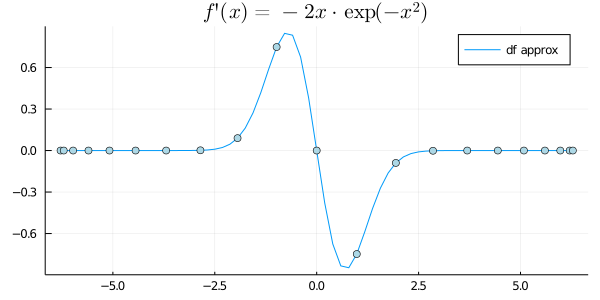

In [940]:
a, b = -2pi, 2pi
N = 100
xrange, df_approx = DChebyshev(f, a, b, N)
plot(xrange, df_approx, label="df approx", title=L"f'(x) = -2x \cdot \exp(-x^2)")
plot!(xrange[begin:5:end], df_approx[begin:5:end], marker=true, linewidth=0, label=nothing, color="lightBlue")

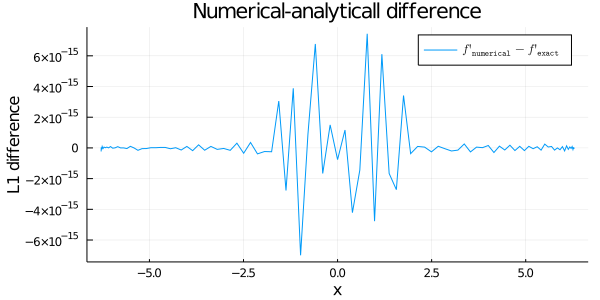

In [941]:
plot(xrange, df.(xrange) - df_approx, ylabel="L1 difference", xlabel="x",
     title="Numerical-analyticall difference", label=L"f'_\texttt{numerical} - f'_\texttt{exact}")

### c) L1 error norm

In this section we show that the difference between our numerical derivatives and the known analytical ones approaches zero. 

You might do this by graphing $\exp(N)\ell_1 \sim C$ or $\log\ell_1 \sim C - N$ for several values of $N$, where $\ell_1 = \sum_{n=0}^N |f'_\texttt{numerical}(x_n) - f'_\texttt{analytical}(x_n)|$

In [942]:
Nmax = 110

Nrange = 1:1:Nmax
l1_values = zeros(length(Nrange))
for (i, N) in enumerate(Nrange)
    xrange, df_approx = DChebyshev(f, a, b, N)
    l1 = sum(abs.(df.(xrange) - df_approx))
    l1_values[i] = l1
end

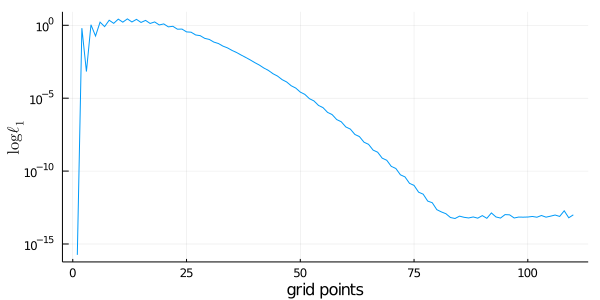

In [943]:
plot(Nrange, l1_values, label=nothing, xlabel="grid points", ylabel=L"\log\ell_1", yaxis=:log)

## Question 2: ODE Integration

Consider the pendulum described by the first-order system

$$
\begin{align*}
\frac{dq}{dt} &= p\\
\frac{dp}{dt} &= f(q)\\
\end{align*}
$$

Where $f(q) = -V'(q) = -\sin(q)$; $V(q) = 1 - \cos(q)$

In [944]:
f(q) = -sin(q)
V(q) = 1 - cos(q)

V (generic function with 1 method)

### Using Runge-Kutta 2

In [945]:
"""
Implementation of a second-order Runge-Kutta ODE
solver

# Arguments
fs: Tuple
    Collection of m functions for the ode
    ẋ = f(x)
initial_conditions: Array
    Collection of m initial conditions
Δt: float
    Timestep size
T: float / int
    Time of integration

Returns
-------
Array of size (T / Δt + 1, m) of the integration
the system from 0 to T
"""
function rk2(fs, initial_conditions, Δt, T)
    yn = initial_conditions[:]
    n_steps = Int(T / Δt + 1)
    n_params = length(initial_conditions)
    
    hist = zeros(n_steps, n_params)
    hist[1, :] = yn
    
    for ti=2:n_steps
        k1 = Δt .* [f(yn...) for f in fs]
        k2 = Δt .* [f(yn + k1 / 2...) for f in fs]
        yn = yn + k2
        hist[ti, :] = yn
    end
    
    return hist
end

rk2

In [946]:
vmin, vmax = -2pi, 2pi

xs = vmin:pi/3:vmax
ys = vmin:pi/3:vmax

df(x, y) = [y, -sin(x)] ./ 3.5

xxs = [x for x in xs for y in ys]
yys = [y for x in xs for y in ys];

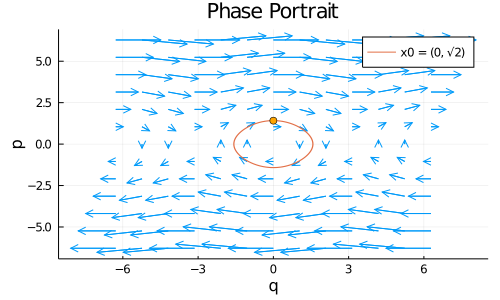

In [947]:
T = 100
dt = 0.1
system = ((q, p) -> p, (q, p) -> f(q))
cond0 = [0, sqrt(2)]
qp_hist = rk2(system, cond0, dt, T)

quiver(xxs, yys, quiver=df, size=(500, 300), xlabel="q", ylabel="p")
plot!(qp_hist[:, 1], qp_hist[:, 2], title="Phase Portrait", label="x0 = (0, √2)")
scatter!(qp_hist[1, [1]], qp_hist[1, [2]], label=nothing, color="orange")

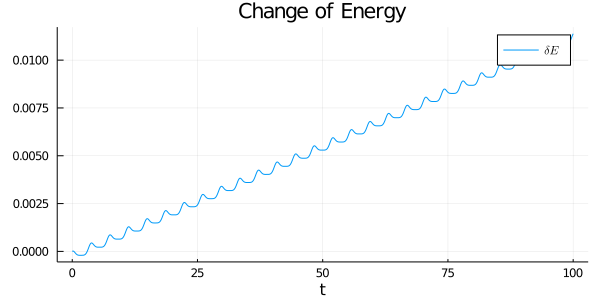

In [948]:
# Energy
E = qp_hist[:, 2] .^ 2 / 2 + V.(qp_hist[:, 1])
plot(0:dt:T, E .- E[begin], title="Change of Energy", label=L"\delta E", xlabel="t")

### Using the Trapezium rule

$$
\begin{align*}
    q(t_{n+1}) - q(t_n) &\approx \frac{\Delta t}{2}[p(t_{n+1} + p_{t_n})]\\
    p(t_{n+1}) - p(t_n) &\approx \frac{\Delta t}{2}\left[f\big(q(t_{n+1})\big) + f\big(q(t_n)\big)\right]\\
\end{align*}
$$

In [949]:
function trapezoidal(fs, initial_conditions, Δt, T, inner_it=10)
    yn = initial_conditions[:]
    n_steps = Int(T / Δt + 1)
    n_params = length(initial_conditions)
    
    hist = zeros(n_steps, n_params)
    hist[1, :] = yn
    
    for ti=2:n_steps
        # RK2 as initial guess
        y_old = rk2(fs, yn, dt, dt)[end, :]
        for _ in 1:inner_it
            y_new = yn + Δt / 2 .* [f(y_old...) + f(yn...) for f in fs]
            y_old = y_new
        end
        yn = y_old
        hist[ti, :] = yn
    end
    
    return hist
end

trapezoidal (generic function with 2 methods)

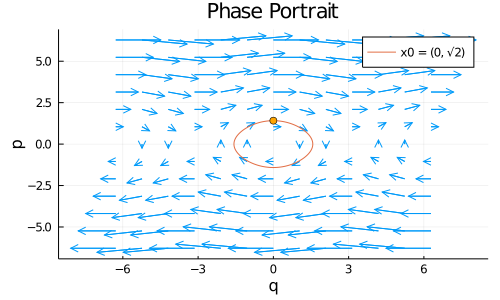

In [950]:
qp_hist = trapezoidal(system, cond0, dt, T)

quiver(xxs, yys, quiver=df, size=(500, 300), xlabel="q", ylabel="p")
plot!(qp_hist[:, 1], qp_hist[:, 2], title="Phase Portrait", label="x0 = (0, √2)")
scatter!(qp_hist[1, [1]], qp_hist[1, [2]], label=nothing, color="orange")

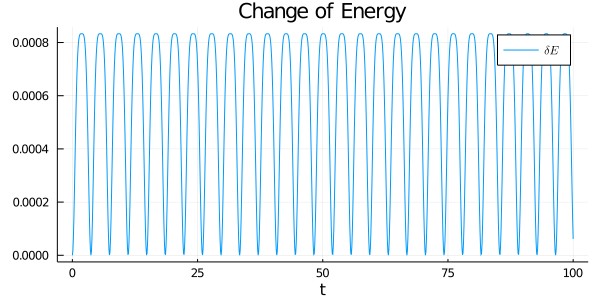

In [951]:
# Energy
E = qp_hist[:, 2] .^ 2 / 2 + V.(qp_hist[:, 1])
plot(0:dt:T, E .- E[begin], title="Change of Energy", label=L"\delta E", xlabel="t")

## Question 3: PDE Integration

$$
\partial_t^2 u - c^2 \partial_x^2 u = 0
$$

First note that if $c=1$, the solution $u_\texttt{analytical}(x) = f(t - x)$ satisfies the wave equation:

$$
\begin{align*}
    \partial_t^2 u - c^2 \partial_x^2 &= f''(t-x) - c^2 f''(t - x)\\
    &= f''(t-x) - f''(t - x)\\
    &= 0
\end{align*}
$$

Denoting $\pi = \partial_t u$, we rewrite the wave equation as follows

$$
\begin{align*}
    \dot u &= \pi\\
    \dot\pi &= c^2\partial_x^2 u
\end{align*}
$$

### b) Solving the wave equation (Runge Kutta)

In this section, we write a program that uses the method of lines to evolve the first-order reduced waved equation.

In [952]:
f(x) = exp(-16x^2)
df(x) = -32x * exp(-16x^2)

df (generic function with 2 methods)

In [953]:
u_analytical(t, x) = f(x - t)

u_analytical (generic function with 1 method)

In [954]:
N = 100
a, b = -1, 1
D = D_chebyshev(a, b, N)
D2 = D ^ 2
D2[begin, :] .= 0
xrange = range_chebyshev(a, b, length=N);

In [955]:
# A memory-inefficient way to solve it
O = zeros(N + 1, N + 1)
L = [O  I; 
     D2 O];

Since $\pi = \partial_t u = \dot u$, and $\dot u(0, x) = -c f'(x)$ we obtain our initial conditions:

$$
\begin{align*}
    \pi(0, x) &= -c f'(x)\\
    u(0, x) &= f(x)
\end{align*}
$$

In [966]:
Δt = 0.05
Δt = 1e-4
T = 0.1
nits = Int(ceil(T / Δt + 1))

Un = [f.(xrange); -df.(xrange)]
U_hist = zeros(nits, 2N + 2)
U_hist[begin, :] = Un

for ti in 2:nits
    U_slack_1 = Un + Δt * L * Un
    U_slack_2 = (3Un + U_slack_1 + Δt * L * U_slack_1) / 4.
    Un = (Un + 2 * U_slack_2 + 2Δt * L * U_slack_2) / 3.
    U_hist[ti, :] = Un
end

U_hist = reshape(U_hist, (nits, N + 1, 2));

In [967]:
nits

1001

In [968]:
t_eval = 0:Δt:T
u_eval = u_analytical.(t_eval[:, new], xrange[new, :])
u_numerical = U_hist[:, :, 1]
u_error = u_eval - u_numerical;

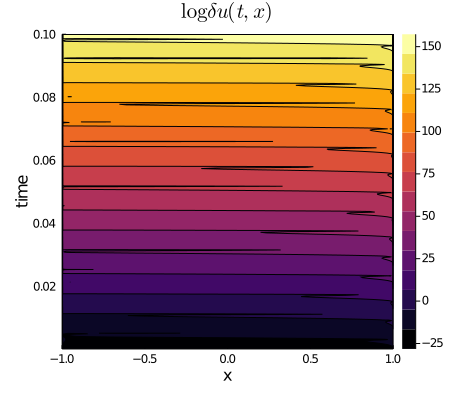

In [969]:
contourf(xrange, t_eval[2:end], log.(abs.(u_error))[2:end, :],
    xlabel="x", ylabel="time", title=L"\log\delta u(t, x)", size=(450, 400))

┌ Info: Saved animation to 
│   fn = /Users/gerardoduran/Documents/repos/QMUL/MTH739U-topics-scientific-computing/exercises/tmp.gif
└ @ Plots /Users/gerardoduran/.julia/packages/Plots/vsE7b/src/animation.jl:104


Plots.AnimatedGif("/Users/gerardoduran/Documents/repos/QMUL/MTH739U-topics-scientific-computing/exercises/tmp.gif")
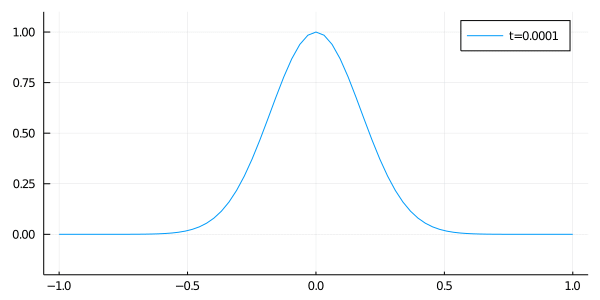

In [972]:
@gif for i in 1:nits
    time = round(Δt * i, digits=5)
    plot(xrange, U_hist[i, :, 1], ylim=(-0.2, 1.1), label="t=$time")
end every 10

### c) Plotting the energy

The total energy of the system at time $t$ is given by

$$
\begin{align*}
        E(t) = \frac{1}{2}\int \big[ (\partial_t u)^2 + c^2 (\partial_x u)^2 \big] dx
\end{align*}
$$

Recalling that $c=1$, we compute the energy of the system from -1 to 1 as follows

$$
\begin{align*}
        E(t) &= \frac{1}{2}\int (\partial_t u)^2 dx + \frac{1}{2}\int (\partial_x u)^2 dx\\
        &\approx \frac{1}{2}\int \pi(t, x) ^ 2 dx + \frac{1}{2}\int \mathbb{D}{\bf u}(t, x) dx \\
        &\approx \frac{1}{2}{\bf w}^T \boldsymbol{\pi}^2(t) + \frac{1}{2}{\bf w}^T (\mathbb{D}{\bf u}(t))^2\\
        &= \frac{1}{2}{\bf w}^T\left[ \boldsymbol{\pi}^2(t) + (\mathbb{D}{\bf u}(t))^2 \right]
\end{align*}
$$

Where ${\bf w}$ is a vector of weights necessary to compute the integral from -1 to 1 using the Clenshaw-Curtis quadrature rule which is given by

$$
    w_n = \begin{cases}
    1 / N ^2 & n \in \{0, N\} \\
    \frac{2}{N}\left(1 - \sum_{k=1}^{(N-1)/2}\frac{2\cos(2k\theta_n)}{4k^2-1}\right) & n\in\{1, \ldots, N-1\}
    \end{cases}
$$

In [978]:
pi_v = U_hist[:, :, 2];

In [979]:
"""
Compute the clenshaw-curtis weights to integrate a
function f from -1 to 1 taking N (+1) steps

# Arguments
- `N::Integer`: Total number of steps - 1
"""
function clenshaw_curtis_weights(N)
    weights = zeros(N + 1)
    theta_N = (0:N) .* pi / N
    for (n, theta_n) in zip(0:N, theta_N)
        if n == 0 || n == N
            w = 1 / N ^ 2
        else
            w = 2 / N * (1 - sum(2cos(2k * theta_n) / (4k^2 - 1) for k=1:(N-1/2)))
        end
        weights[n+1] = w
    end
    return weights
end

clenshaw_curtis_weights

In [980]:
w_cc = clenshaw_curtis_weights(N);

In [981]:
@time begin
    @einsum Du[t, xi] := D[xi, x] * u_numerical[t, x]
end;

  1.751464 seconds (51.36 M allocations: 943.324 MiB, 10.35% gc time)


In [982]:
@time begin
    @einsum E[t] := w_cc[x] * (pi_v[t, x] ^ 2 + (Du[t, x]) ^ 2)
end;

  0.044351 seconds (912.90 k allocations: 15.511 MiB)


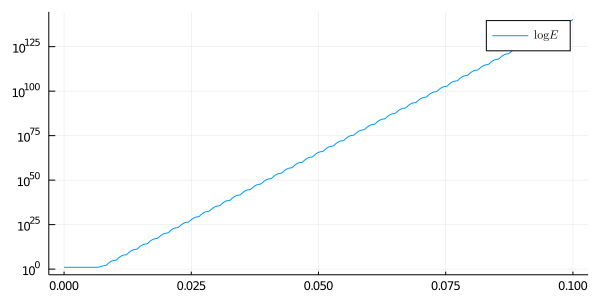

In [983]:
plot(t_eval, E, yaxis=:log, label=L"\log E")

### d) Solving the wave equation (Trapezium)

In this section, we write a program that uses the method of lines to evolve the first-order reduced waved equation.

As before, we consider the ODE system

$$
\begin{align*}
    \dot u &= \pi\\
    \dot\pi &= c^2\partial_x^2 u
\end{align*}
$$

With $\pi = \partial_t u$

The trapezium reule fot the wave equation yields a system of the form

$$
\begin{align*}
    {\bf u}_{n+1} - {\bf u}_n &= \int_{t_n}^{t_{n+1}} {\boldsymbol\pi}(t) dt \approx \frac{\Delta t}{2}(\boldsymbol\pi_{n+1} + \boldsymbol\pi_{n})\\
    {\boldsymbol \pi}_{n+1} - {\boldsymbol \pi}_n &= \int_{t_n}^{t_{n+1}} {\bf D}^2{\bf u}(t) dt \approx \frac{\Delta t}{2}{\bf D}^2({\bf u}_{n+1} + {\bf u}_{n})\\
\end{align*}
$$

Solving the system for ${\bf u}_{n+1}$, $\boldsymbol\pi_{n+1}$ yields

$$
    \boldsymbol\pi_{n+1} \approx \left[{\bf I} - \frac{(\Delta t)^2}{4}{\bf D}^2 \right]^{-1}\left[ \left({\bf I} + \frac{(\Delta t)^2}{4}{\bf D}^2\right)\boldsymbol\pi_{n} + \Delta t {\bf D}^2 {\bf u}_n\right]
$$

$$
    {\bf u}_{n+1} \approx \frac{\Delta t}{2} (\boldsymbol\pi_{n+1} + \boldsymbol\pi_{n}) + {\bf u}_n
$$

In [984]:
"""
# Build a differentiation matrix

This function builds a differentiation matrix required to compute
a second-order finite-differences method assuming equidistant points

# Arguments
- `x_grid::StepRangeLen`: Points at which to evaluate the derivative
- `Δx::Float`: Step size
"""
function build_diff_matrix(x_grid, Δx)
    n_grid = length(x_grid)
    D = zeros(n_grid, n_grid)
    
    for row in 1:n_grid
        if row == 1
            # Left-difference formula
            D[row, row] = -3
            D[row, row + 1] = 4
            D[row, row + 2] = -1
        elseif row == n_grid
            # Right-difference formula
            D[row, row - 2] = 1
            D[row, row - 1] = -4
            D[row, row] = 3
        else
            # Central-difference formula
            D[row, row - 1] = -1
            D[row, row] = 0
            D[row, row + 1] = 1
        end
    end
    
    D = D ./ 2Δx
    return D
end

build_diff_matrix

In [990]:
a, b, N = -1, 1, 100
xrange = range(a, b, length=N+1)
Δx = round(xrange.step.hi, digits=4)


Δt = 0.001

u_n = f.(xrange)
π_n = -df.(xrange);

D = build_diff_matrix(xrange, Δx)
D2 = D ^ 2
D2[begin, :] .= 0;

In [991]:
u_n = f.(xrange)
π_n = -df.(xrange);

In [992]:
T = 0.5
nits = Int(ceil(T / Δt) + 1)

U_hist = zeros(nits, 2, N+1)

U_hist[begin, 1, :] = u_n
U_hist[begin, 2, :] = π_n;

for ti=2:nits
    M1 = I - Δt ^ 2 / 4 * D2
    M2 = (I + Δt ^ 2 / 4 * D2) * π_n + Δt * D2 * u_n

    π_n1 = M1 \ M2
    u_n1 = Δt / 2 * (π_n + π_n1) + u_n
    
    U_hist[ti, 1, :] = u_n1
    U_hist[ti, 2, :] = π_n1
    
    u_n = u_n1
    π_n = π_n1
end

┌ Info: Saved animation to 
│   fn = /Users/gerardoduran/Documents/repos/QMUL/MTH739U-topics-scientific-computing/exercises/tmp.gif
└ @ Plots /Users/gerardoduran/.julia/packages/Plots/vsE7b/src/animation.jl:104


Plots.AnimatedGif("/Users/gerardoduran/Documents/repos/QMUL/MTH739U-topics-scientific-computing/exercises/tmp.gif")
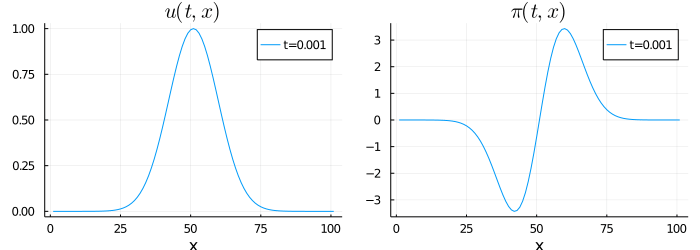

In [993]:
@gif for i in 1:nits
    time = round(Δt * i, digits=5)
    p1 = plot(U_hist[i, 1, :], label="t=$time", title=L"u(t, x)", xlabel="x")
    p2 = plot(U_hist[i, 2, :], label="t=$time", title=L"\pi(t,x)", xlabel="x")
    plot(p1, p2, layout=(1, 2), size=(700, 250), suptitle="df")
end every 10